# **1**. Download and process the data into a pandas Dataframe.

In [55]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dates' : ['Date', 'Time']}, infer_datetime_format=True, index_col='dates', low_memory=False, na_values=['nan','?'])
clustering_cols = ['Date', 'Time','Global_active_power']
df_og = pd.read_csv('household_power_consumption.txt', sep=';', usecols=clustering_cols)
df.head()
df.isnull().sum()
# Replacing nan with mean in any columns
for i in range(0,7):        
    df.iloc[:,i]=df.iloc[:,i].fillna(df.iloc[:,i].mean())
#df.isnull().sum()
#df.info()
#df.shape
power_consumption = (df['Global_active_power']*1000/60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']) 
df['power_consumption'] = power_consumption
df.head()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power_consumption
dates,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


# **2.** Visualize the data. It’s a very large dataset, how can we plot it in a way that a human understands its main features?

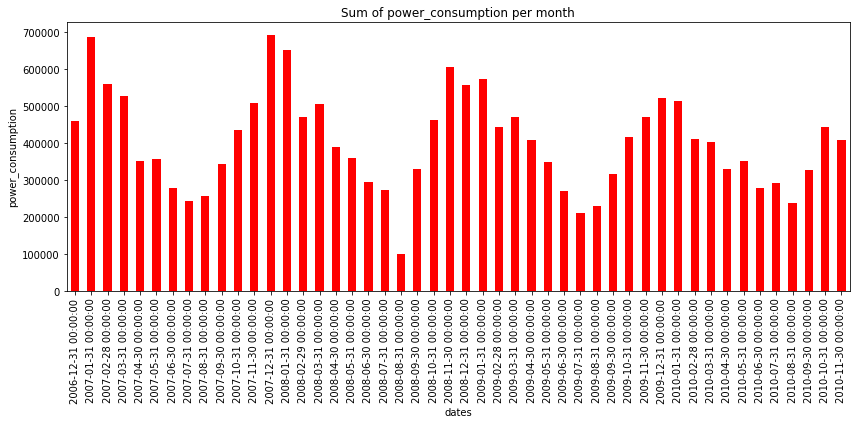

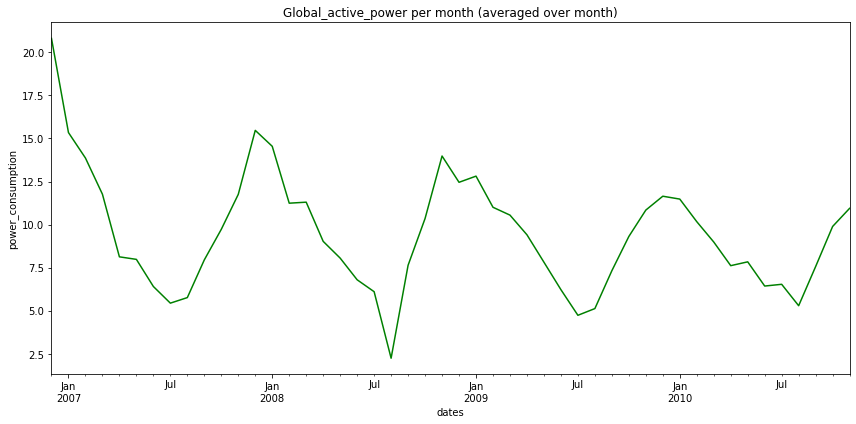

In [4]:
plt.figure(figsize=(12,6))
df.power_consumption.resample('M').sum().plot(title='Sum of power_consumption per month', kind='bar', color='red')
plt.ylabel('power_consumption') 
plt.tight_layout()
plt.show()   
plt.figure(figsize=(12,6))
df.power_consumption.resample('M').mean().plot(title='Global_active_power per month (averaged over month)', color='green') 
plt.ylabel('power_consumption')
plt.tight_layout()
plt.show()

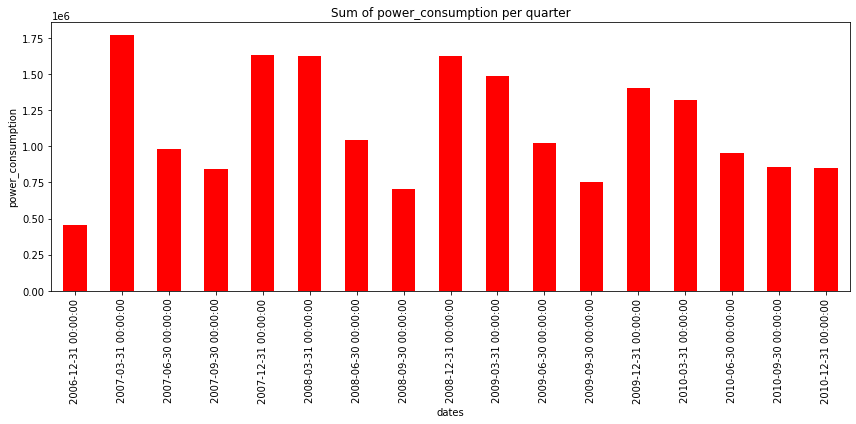

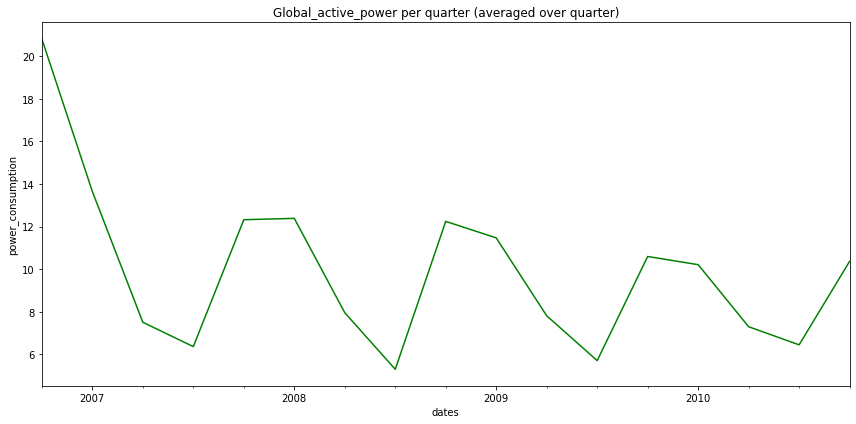

In [5]:
plt.figure(figsize=(12,6))
df.power_consumption.resample('Q').sum().plot(title='Sum of power_consumption per quarter', kind='bar', color='red')
plt.ylabel('power_consumption') 
plt.tight_layout()
plt.show()   
plt.figure(figsize=(12,6))
df.power_consumption.resample('Q').mean().plot(title='Global_active_power per quarter (averaged over quarter)', color='green') 
plt.ylabel('power_consumption')
plt.tight_layout()
plt.show()

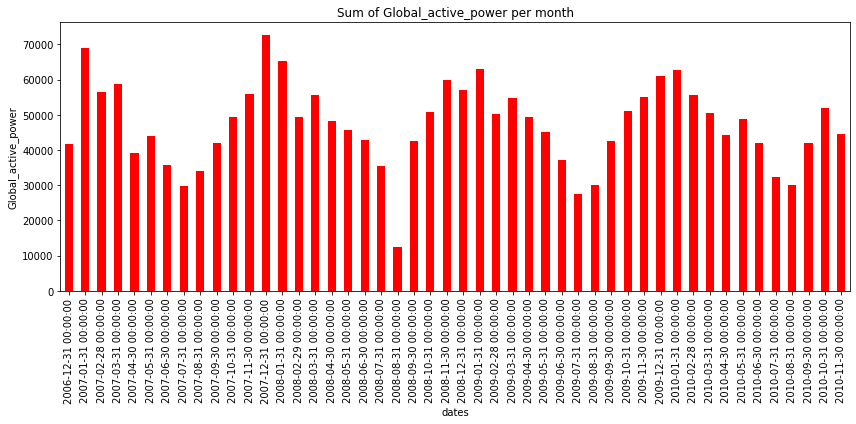

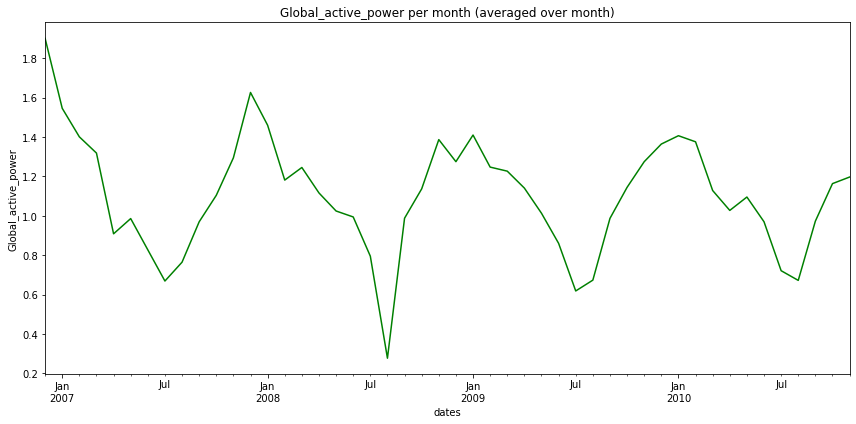

In [6]:
plt.figure(figsize=(12,6))
df.Global_active_power.resample('M').sum().plot(title='Sum of Global_active_power per month', kind='bar', color='red')
plt.ylabel('Global_active_power') 
plt.tight_layout()
plt.show()   
plt.figure(figsize=(12,6))
df.Global_active_power.resample('M').mean().plot(title='Global_active_power per month (averaged over month)', color='green') 
plt.ylabel('Global_active_power')
plt.tight_layout()
plt.show()

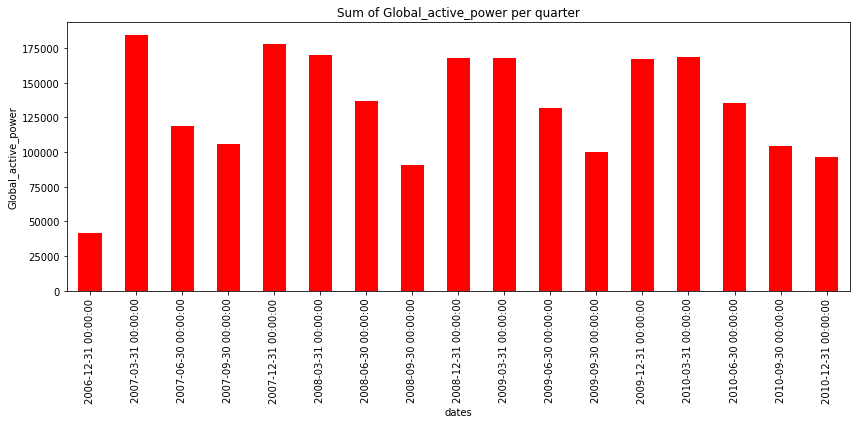

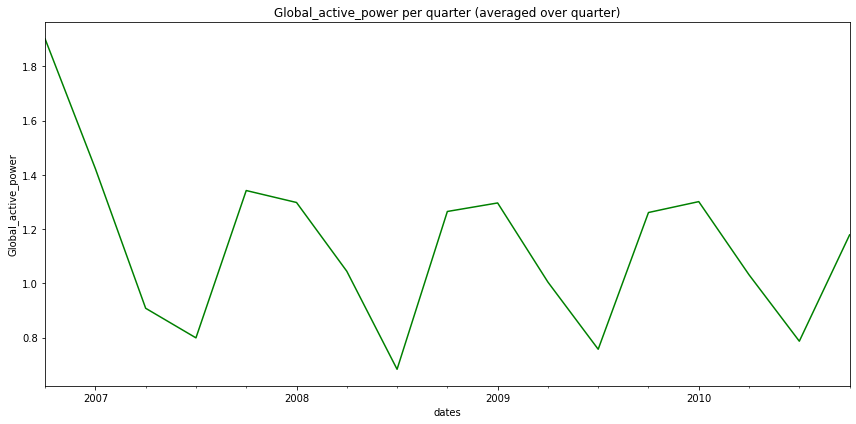

In [7]:
plt.figure(figsize=(12,6))
df.Global_active_power.resample('Q').sum().plot(title='Sum of Global_active_power per quarter', kind='bar', color='red')
plt.ylabel('Global_active_power') 
plt.tight_layout()
plt.show()   
plt.figure(figsize=(12,6))
df.Global_active_power.resample('Q').mean().plot(title='Global_active_power per quarter (averaged over quarter)', color='green') 
plt.ylabel('Global_active_power')
plt.tight_layout()
plt.show()

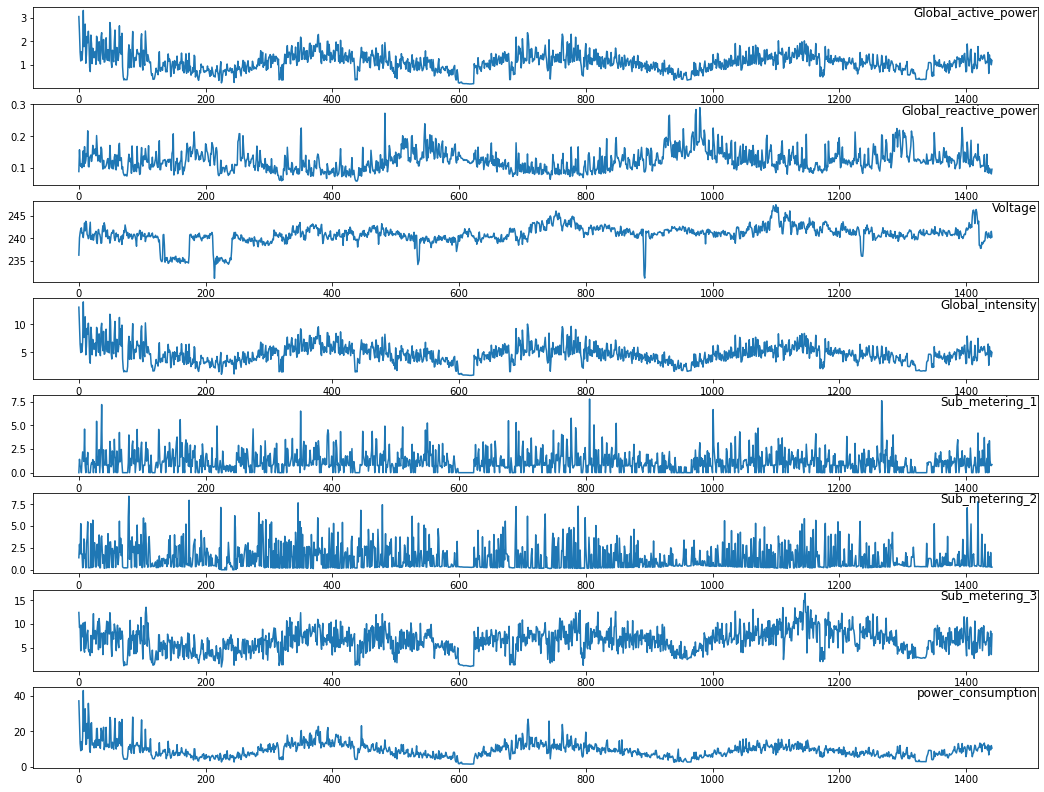

In [8]:
#Comparing the mean of different features resampled over day. 
cols = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
values = df.resample('D').mean().values
plt.figure(figsize=(18, 14))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, col])
	plt.title(df.columns[col], y=0.8, loc='right')
	i += 1
plt.show()

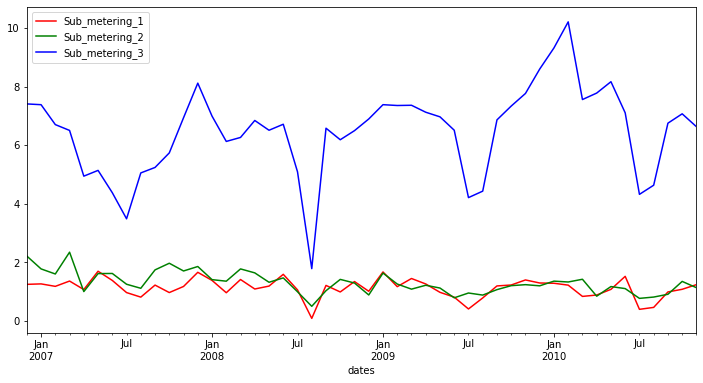

In [9]:
plt.figure(figsize=(12, 6))
df.Sub_metering_1.resample('M').mean().plot(color='r', legend=True)
df.Sub_metering_2.resample('M').mean().plot(color='g', legend=True)
df.Sub_metering_3.resample('M').mean().plot(color='b', legend=True)
plt.show()

**Conclusion**: A general trend over the years suggests that power consumption of any type takes a dip in the months around July and August every year at this house.

Also, the peak of power consumption seems to repeat itself around the month of December and January each year at the given household. 

# **3**. Using a clustering method, identify different power usage patterns of the household.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


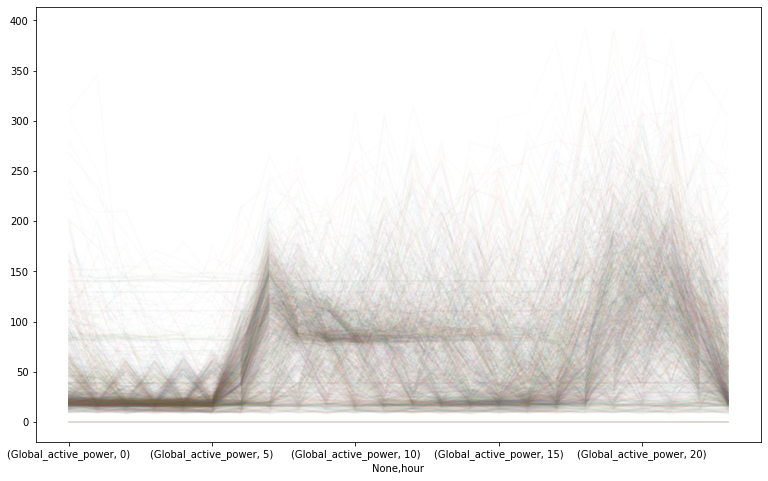

In [10]:
df_og['datetime'] = pd.to_datetime(df_og['Date'] + ' '+ df_og['Time'])
df_og = df_og.drop(['Date','Time'], axis=1)
df_og = df_og.set_index('datetime')

df_og = df_og.replace('?', np.nan)
df_og = df_og.astype(np.float).fillna(method='bfill')

df_hourly = df_og.resample('H').sum()
df_hourly['hour'] = df_hourly.index.hour
df_hourly.index = df_hourly.index.date

df_hourly_pivot = df_hourly.pivot(columns='hour')
df_hourly_pivot = df_hourly_pivot.dropna()

df_hourly_pivot.T.plot(figsize=(13,8), legend=False, alpha=0.02)



Above is a graph that consists of all the data points in the dataset representing energy consumption of the household on the daily basis.

In [11]:
!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 25.0 MB/s 


In [ ]:
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(df_hourly_pivot)

TimeSeriesKMeans(max_iter=10, metric='dtw')

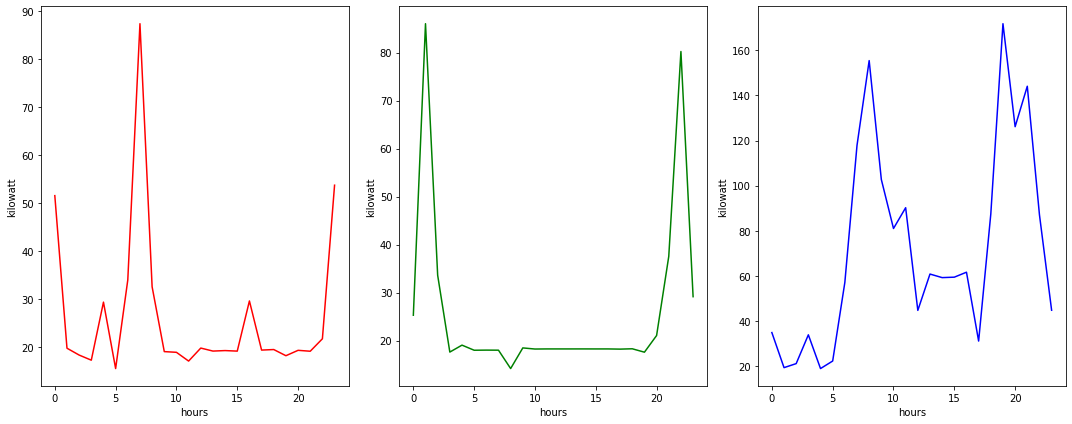

In [30]:
plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
plt.plot(model.fit(df_hourly_pivot).cluster_centers_[0].ravel(), "r-")
plt.xlabel('hours')
plt.ylabel('kilowatt')
plt.subplot(1, 3, 2)
plt.plot(model.fit(df_hourly_pivot).cluster_centers_[1].ravel(), "g-")
plt.xlabel('hours')
plt.ylabel('kilowatt')
plt.subplot(1, 3, 3)
plt.plot(model.fit(df_hourly_pivot).cluster_centers_[2].ravel(), "b-")
plt.xlabel('hours')
plt.ylabel('kilowatt')
plt.tight_layout()
plt.show()



Applying k-means clustering with different k values, I have settled on k=3 as these 3 patterns seemed to provide most contrast to the given dataset. And also it explains a story.
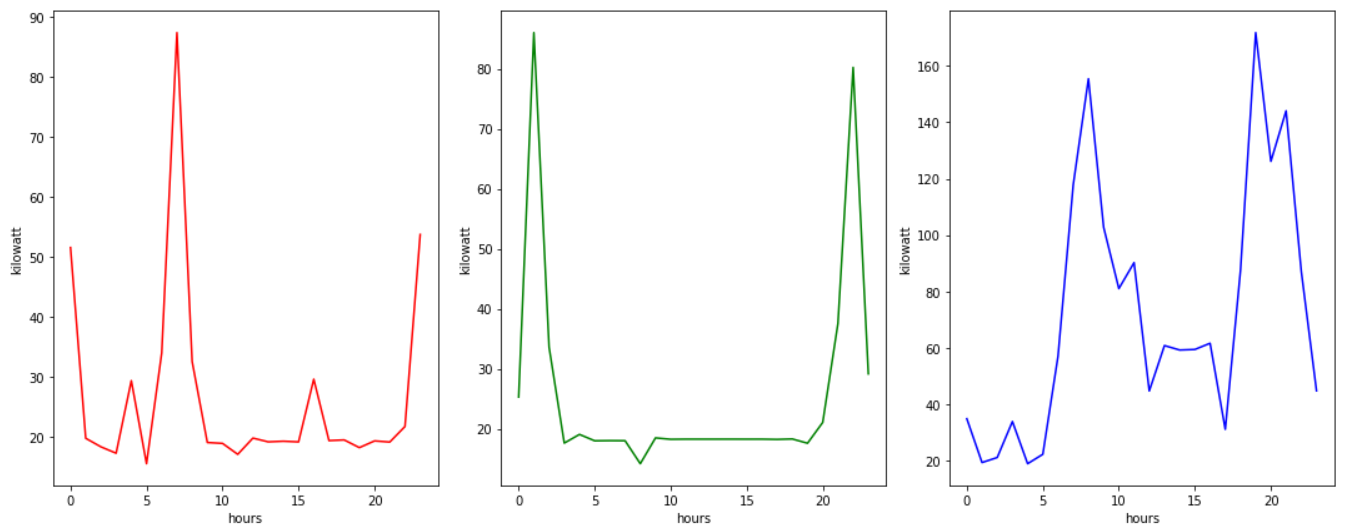

(I have taken a screenshot of the graph as the color kept changing with each run. It would be easier to explain this way.)

Red one seems to be a usual weekday where the graph peaks in the morning, settles in the day-hours and then again goes up in the evening.

Green one gives out a pattern for the weekends. As late-night use of energy seems high and then it is steady over the day.

Blue one gives out an impression of holidays as the power consumption in the house is high overall and peaks at usual family affair timings.

# **4**. Using a time series regression method, predict the next month’s consumption patterns.

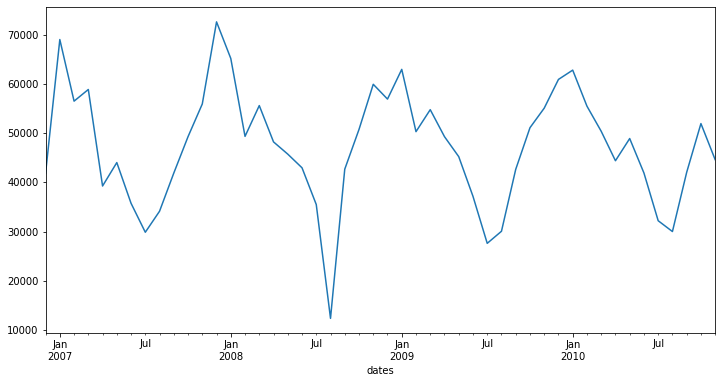

In [12]:
df_monthly = pd.DataFrame()
df_monthly = df.Global_active_power.resample('M').sum()
df_monthly.columns = ['Global_active_power']
df_monthly.plot(figsize=(12,6))
              

In [13]:

x = df_monthly.to_numpy()
y = df_monthly.index
df_monthly_sum = pd.DataFrame({'Date':y, 'Power':x})
df_monthly_sum['Power_1Monthback']=df_monthly_sum['Power'].shift(+1)
df_monthly_sum['Power_2Monthsback']=df_monthly_sum['Power'].shift(+2)
df_monthly_sum['Power_3Monthsback']=df_monthly_sum['Power'].shift(+3)
df_monthly_sum=df_monthly_sum.dropna()
df_monthly_sum.tail()

,Date,Power,Power_1Monthback,Power_2Monthsback,Power_3Monthsback
43,2010-07-31,32188.843615,41887.607230,48893.491615,44379.215615
44,2010-08-31,29991.384254,32188.843615,41887.607230,48893.491615
45,2010-09-30,42026.211946,29991.384254,32188.843615,41887.607230
46,2010-10-31,51934.045615,42026.211946,29991.384254,32188.843615
47,2010-11-30,44598.388000,51934.045615,42026.211946,29991.384254


In [14]:
from sklearn.linear_model import LinearRegression
lin_model=LinearRegression()
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=100,max_features=3, random_state=1)

#pre-processing
import numpy as np
x1,x2,x3,y=df_monthly_sum['Power_1Monthback'],df_monthly_sum['Power_2Monthsback'],df_monthly_sum['Power_3Monthsback'],df_monthly_sum['Power']
x1,x2,x3,y=np.array(x1),np.array(x2),np.array(x3),np.array(y)
x1,x2,x3,y=x1.reshape(-1,1),x2.reshape(-1,1),x3.reshape(-1,1),y.reshape(-1,1)
final_x=np.concatenate((x1,x2,x3),axis=1)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


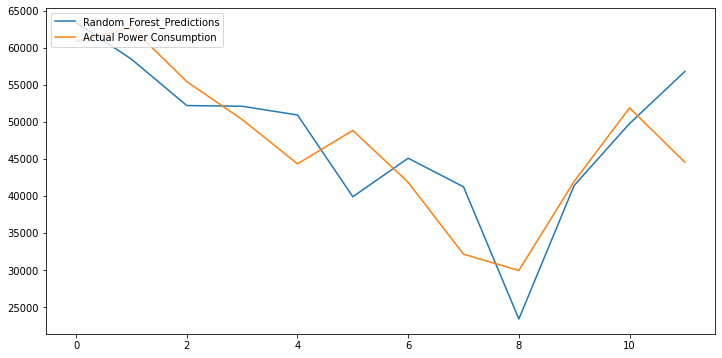

In [26]:
X_train,X_test,y_train,y_test=final_x[:-12],final_x[-12:],y[:-12],y[-12:]
model.fit(X_train,y_train)
lin_model.fit(X_train,y_train)

pred=model.predict(X_test)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(pred,label='Random_Forest_Predictions')
plt.plot(y_test,label='Actual Power Consumption')
plt.legend(loc="upper left")
plt.show()

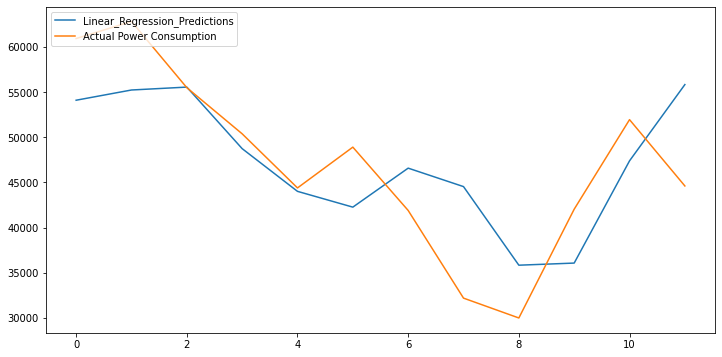

In [27]:
lin_pred=lin_model.predict(X_test)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(lin_pred,label='Linear_Regression_Predictions')
plt.plot(y_test,label='Actual Power Consumption')
plt.legend(loc="upper left")
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_rf=sqrt(mean_squared_error(pred,y_test))
rmse_lr=sqrt(mean_squared_error(lin_pred,y_test))
print('Mean Squared Error for Random Forest Model is:',rmse_rf)
print('Mean Squared Error for Linear Regression Model is:',rmse_lr)

lin_pred=model.predict(final_x[-1:])
#print(final_x[-1:])
last_month_pred = np.array(lin_pred)
last_month_data = final_x[-1:][0][1:]
last_month_data = np.append (last_month_pred, last_month_data)
last_month_data = np.reshape(last_month_data, (-1, 3))
#last_month_data
next_month_prediction=model.predict(last_month_data)
print('The next month’s consumption prediction:', next_month_prediction)


Mean Squared Error for Random Forest Model is: 6145.206414956645
Mean Squared Error for Linear Regression Model is: 6716.303369308424
The next month’s consumption prediction: [58636.1252618]


Random forest regression seems to working better in compare to Linear Regression. Applying random forest model for the prediction of the next month's power consumption it came out to 58636.1252618 kW.

# **5**. Using publicly available data, estimate the GHG Scope 2 emissions of the household on a monthly basis.

After searching for scope 2 emission data on internet, I found a concrete data i.e. for Australia. I am using this data to impose in this household case also. My assumption on scope 2 emission would be 0.65 kg/CO2-e kWh.

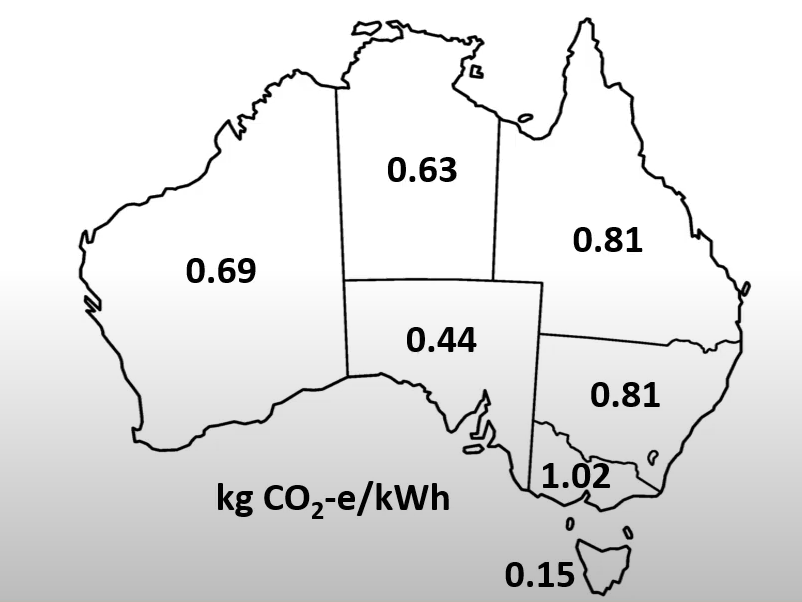

Scope 2 emissions are indirect GHG emissions associated with the purchase of electricity, steam, heat, or cooling.

So, I am considering global_reactive_power to calculate scope 2 emissions of this particular household.

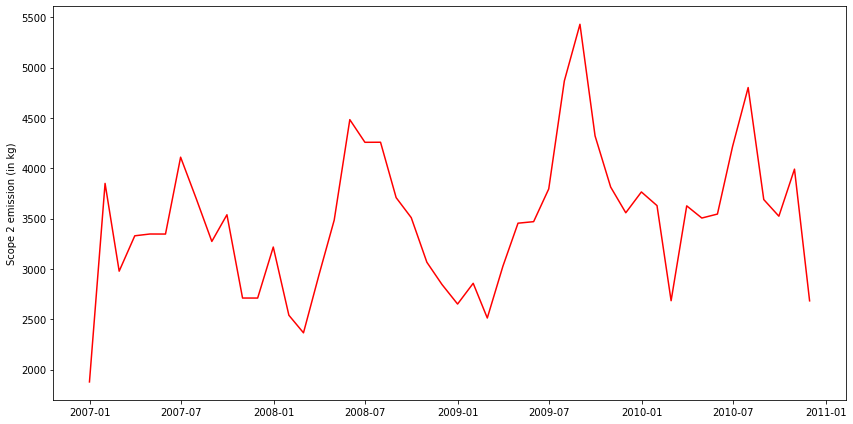

In [94]:
df_global_reactive_monthly = df.Global_reactive_power.resample('M').sum()
x = df_global_reactive_monthly.to_numpy()
y = df_global_reactive_monthly.index
df_global_reactive_monthly_sum = pd.DataFrame({'Date':y, 'Power':x, 'Scope_2_emission': x*0.65})
plt.figure(figsize=(12,6))
plt.plot(df_global_reactive_monthly_sum['Date'], df_global_reactive_monthly_sum['Scope_2_emission'], color='red');
plt.ylabel('Scope 2 emission (in kg)') 
plt.tight_layout() 
plt.show()

# **6**. Assuming a hypothetical grid where generated power is mostly renewables during the day, and fossil fuels at night, identify potential changes to the household’s patterns to minimize its GHG emissions.

Let's consider power generated by renwables is between 6AM to 6PM.

And, power generated by fossil fuels is between 6PM to 6AM.

As GHG emissions are directly propotional to the power consumed, here I am going to consider sub_metering_1, sub_metering_2 and sub_metering_3 data to determine the GHG emissions.

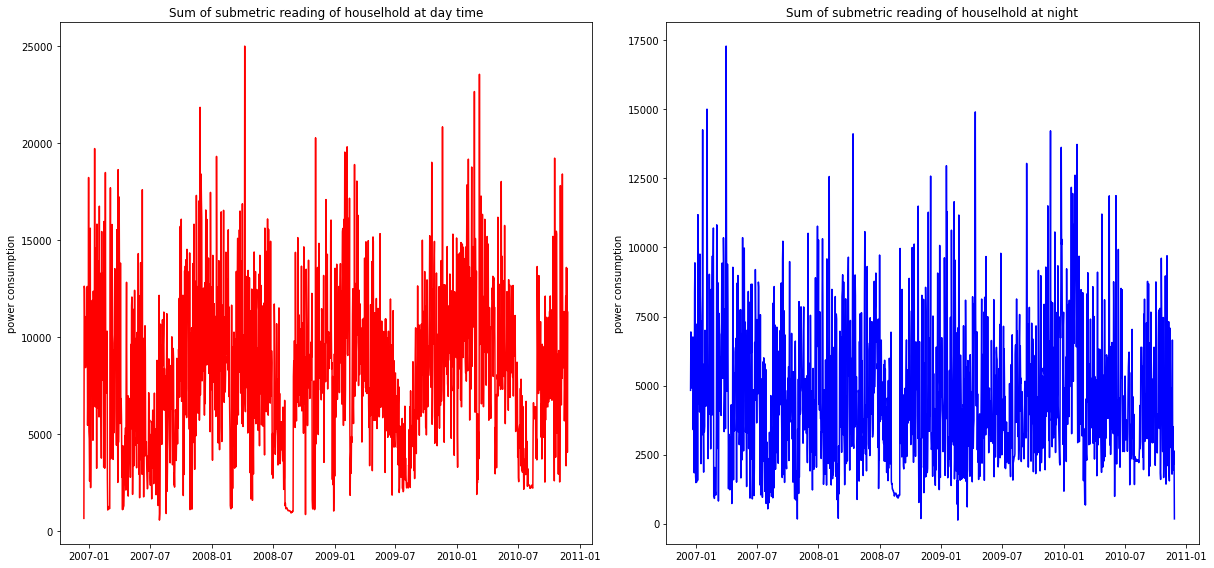

In [69]:
y = df.index
x1 = df['Sub_metering_1'].to_numpy()
x2 = df['Sub_metering_2'].to_numpy()
x3 = df['Sub_metering_3'].to_numpy()
df_ghg = pd.DataFrame({'Sum_of_sub_meter': x1 + x2 + x3}, index=y)
df_ghg_daytime = df_ghg.between_time('6:00', '18:00').resample('D').sum() # to calculate GHG emission at daytime per-day from the household
df_ghg_night = df_ghg.between_time('18:01', '05:59').resample('D').sum() # to calculate GHG emission at night per-day from the household
plt.figure(figsize=(17,8))
plt.subplot(1, 2, 1)
plt.plot(df_ghg_daytime, color='red')
plt.title('Sum of submetric reading of houselhold at day time') 
plt.ylabel('power consumption') 
plt.subplot(1, 2, 2)
plt.plot(df_ghg_night, color='blue')
plt.title('Sum of submetric reading of houselhold at night') 
plt.ylabel('power consumption') 
plt.tight_layout()
plt.show()   



It is clear from data that usually at night (6PM-6AM) households are consuming less energy, but the energy which is being consumed at night is from fossil fuels. As the energy produced at daytime is from renewable resouces we do not need to worry about any emission at daytime.

Now the next step is to identify which particular meter do we need to look at to cut the GHG emission further. Basically, we have to suggest household to change thier energy consumption pattern and do as much as consumption of their share in daytime to cut the GHG emission as much as possible.

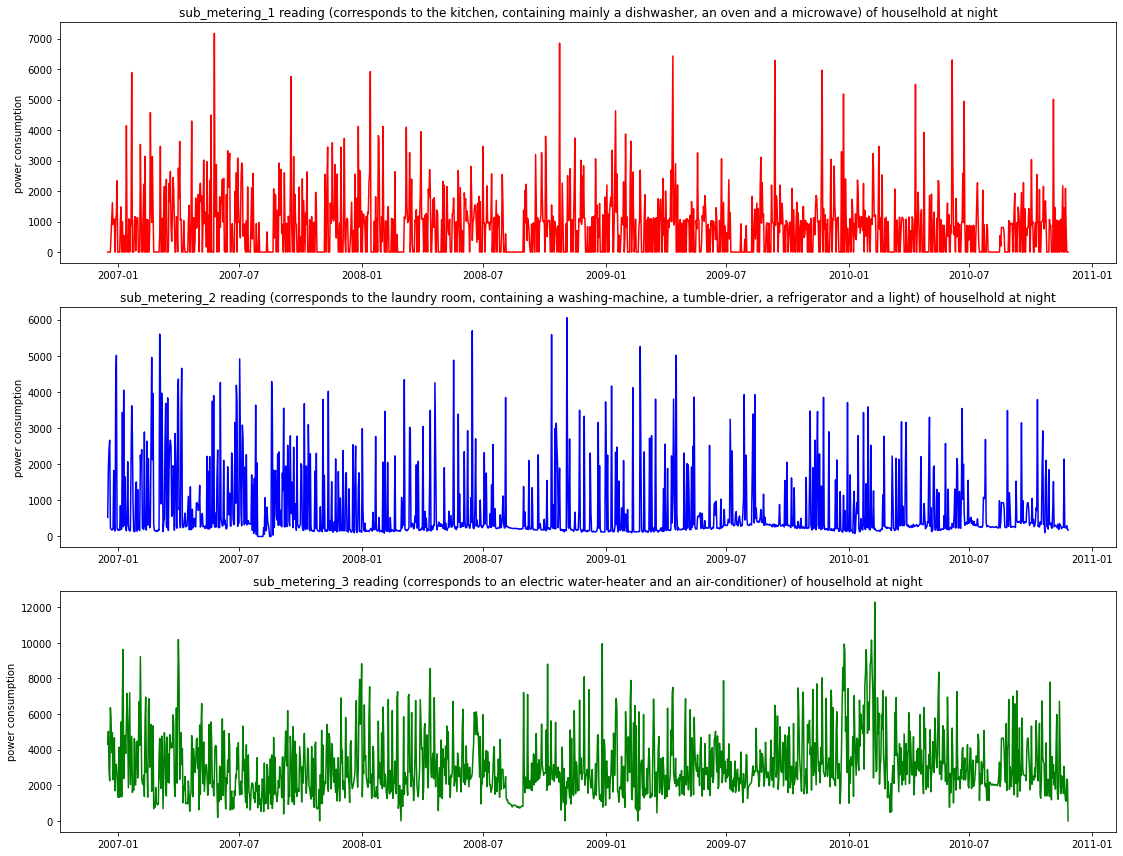

In [77]:
df_ghg_night_1 = pd.DataFrame({'Sub_metering_1': x1}, index=y).between_time('18:01', '05:59').resample('D').sum()
df_ghg_night_2 = pd.DataFrame({'Sub_metering_2': x2}, index=y).between_time('18:01', '05:59').resample('D').sum()
df_ghg_night_3 = pd.DataFrame({'Sub_metering_3': x3}, index=y).between_time('18:01', '05:59').resample('D').sum()

plt.figure(figsize=(16,12))
plt.subplot(3, 1, 1)
plt.plot(df_ghg_night_1, color='red')
plt.title('sub_metering_1 reading (corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave) of houselhold at night') 
plt.ylabel('power consumption') 
plt.subplot(3, 1, 2)
plt.plot(df_ghg_night_2, color='blue')
plt.title('sub_metering_2 reading (corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light) of houselhold at night') 
plt.ylabel('power consumption') 
plt.subplot(3, 1, 3)
plt.plot(df_ghg_night_3, color='green')
plt.title('sub_metering_3 reading (corresponds to an electric water-heater and an air-conditioner) of houselhold at night') 
plt.ylabel('power consumption') 
plt.tight_layout()
plt.show()   

In [86]:
print('Average per-day Sub-metric 1 reading for the night time:', df_ghg_night_1['Sub_metering_1'].mean())
print('Average per-day Sub-metric 2 reading for the night time:', df_ghg_night_2['Sub_metering_2'].mean())
print('Average per-day Sub-metric 3 reading for the night time:', df_ghg_night_3['Sub_metering_3'].mean())

Average per-day Sub-metric 1 reading for the night time: 816.4110328492762
Average per-day Sub-metric 2 reading for the night time: 714.2914711031285
Average per-day Sub-metric 3 reading for the night time: 3092.047280381375


**Suggestion**: To reduce the GHG emission we need to make people aware of the timings of the energy used in the power grid and will need to make people use their energy-intense appliance in daytime (6AM - 6PM).

Sub-meter 3 by all readings seem more energy-intensive. So, while changing energy consumption pattern we will need to look into how to make household use of electric water-heater and air-conditioner minimal in night time.

Although, sub-meter 2 does not contribute much to the energy consumption takes place at night time as sub-meter 3 does, but there is a scope of cutting energy consumption (like washing-machine and tumble-drier use) at night and try to push it to day time. 